# Connectivity across groups

This notebook contains the code for the descriptive analysis of the connectivity across experimental groups: AVGP and NVGP.

## TODO
    t-test

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path
import xarray as xr
import scipy.stats as stats
import numpy as np
from src.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     cross_val_score, learning_curve,
                                     permutation_test_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm
from IPython.display import clear_output

from src.acnets.pipeline import Parcellation

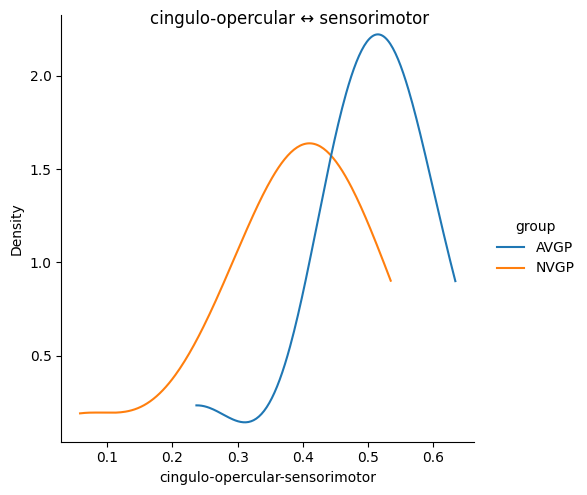

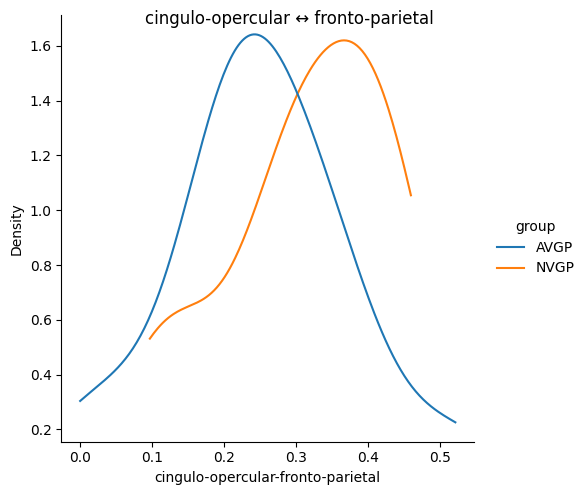

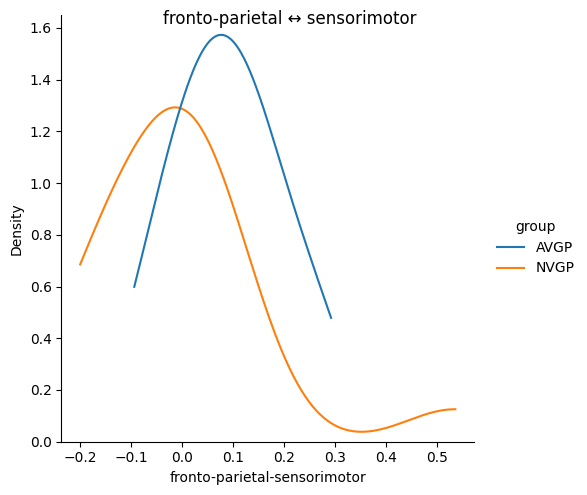

In [2]:
pipe = ConnectivityPipeline(atlas='dosenbach2010',
                            kind='partial correlation',
                            timeseries_aggregation='network')
pipe.fit_transform(None)
data = pipe.dataset_

import seaborn as sns
import matplotlib.pyplot as plt

def plot_connectivity_dist(data, src, dst):

    avgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('AVGP')])
    nvgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('NVGP')])

    avgp_conn = avgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)
    nvgp_conn = nvgp['connectivity'].sel(
        network_src=src,
        network_dst=dst)

    conn_name = f'{src}-{dst}'
    plot_data = pd.concat([
        pd.DataFrame(avgp_conn.values, columns=[conn_name]).assign(group='AVGP'),
        pd.DataFrame(nvgp_conn.values, columns=[conn_name]).assign(group='NVGP')
    ]).reset_index(drop=True)

    sns.displot(plot_data, x=conn_name, hue='group', kind='kde', cut=0)
    plt.suptitle(f'{src} \N{left right arrow} {dst}')
    plt.show()



plot_connectivity_dist(data, 'cingulo-opercular', 'sensorimotor')
# DEBUG to make sure connectivity is symmetric
# plot_connectivity_dist(data, 'sensorimotor', 'cingulo-opercular')
plot_connectivity_dist(data, 'cingulo-opercular', 'fronto-parietal')
plot_connectivity_dist(data, 'fronto-parietal', 'sensorimotor')


In [25]:
import pingouin as pg

avgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('AVGP')])
nvgp = data.sel(subject=[s for s in data['subject'].values if s.startswith('NVGP')])

def report_ttest(src, dst):
        
    avgp_conn = avgp['connectivity'].sel(
        network_src=src,
        network_dst=dst).values
    nvgp_conn = nvgp['connectivity'].sel(
        network_src=src,
        network_dst=dst).values

    # con-smn (H1: AVGP > NVGP)
    from IPython.display import display
    results = pg.ttest(avgp_conn, nvgp_conn, paired=False, correction=True, alternative='greater')

    print(f'{src} \N{left right arrow} {dst} (H1: AVGP > NVGP)')
    display(results)

report_ttest('cingulo-opercular', 'sensorimotor')
report_ttest('fronto-parietal', 'sensorimotor')
report_ttest('cingulo-opercular', 'fronto-parietal')


cingulo-opercular ↔ sensorimotor (H1: AVGP > NVGP)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.190992,28.129259,greater,0.001736,"[0.06, inf]",1.128186,23.742,0.929612


fronto-parietal ↔ sensorimotor (H1: AVGP > NVGP)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.748512,25.066664,greater,0.046307,"[0.0, inf]",0.618192,2.112,0.525532


cingulo-opercular ↔ fronto-parietal (H1: AVGP > NVGP)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.5065,29.802747,greater,0.928767,"[-0.13, inf]",0.532628,0.632,0.00091
